# Tweets during the 2021 Abu Dhabi Grand Prix 

Race start: 12 December 2021, 1:00PM (GMT)


In [ ]:
# Clone repo
!git clone --depth=1 https://github.com/twintproject/twint.git
!cd /content/twint && pip3 install . -r requirements.txt 

# Override with older 3.7.0 to avoid error with latest 3.8.1
!pip install aiohttp==3.7.0 

import twint
import nest_asyncio
nest_asyncio.apply()

import time
import pandas as pd
import matplotlib.pyplot as plt

## Scraping

In [ ]:
## List of search terms: hashtags, drivers, persons of interest, nicknames
# Note: tweet will be scraped multiple times if tweet contains >1 terms
search_terms = ['#AbuDhabiGP', '#F1Finale', '#F1', '#Formula1', 
                'Max Verstappen', 'Max33Verstappen', 'Super Max',  
                'Lewis Hamilton', 'LewisHamilton', 'Crymilton', '#KingLewis',
                'Sergio Checo Perez', 'SChecoPerez', 
                'Latifi', 'Goatifi', 
                'Michael Masi', '#MasiOut', 'FIA', '#MaFIA',
                'MercedesAMGF1', 'RedBullRacing']

search_terms_concat = '"' + '" OR "'.join(search_terms) + '"'
search_terms_concat

'"#AbuDhabiGP" OR "#F1Finale" OR "#F1" OR "#Formula1" OR "Max Verstappen" OR "Max33Verstappen" OR "Super Max" OR "Lewis Hamilton" OR "LewisHamilton" OR "Crymilton" OR "#KingLewis" OR "Sergio Checo Perez" OR "SChecoPerez" OR "Latifi" OR "Goatifi" OR "Michael Masi" OR "#MasiOut" OR "FIA" OR "#MaFIA" OR "MercedesAMGF1" OR "RedBullRacing"'

In [ ]:
## Configure the twint object
# Rerun if RefreshTokenException, or if tweet_scraper changes did not take effect
c = twint.Config()

In [ ]:
# Function scrape tweets
def tweet_scraper(start_dt, end_dt, terms, output_path):
  start_time = time.time()
  # Set parameters
  #c.Limit = 1000
  c.Lang = "en"               # does not work, see issue 1025
  c.Native_retweets = False   # some hiccups, see issue 630
  c.Pandas = True 
  c.Hide_output = True
  c.Search = terms
  c.Since = start_dt          # GMT+0, inclusive
  c.Until = end_dt            # exclusive
  # Execute the query
  twint.run.Search(c)
  # Output (all languages) 
  cols = ['date', 'timezone', 'tweet', 'language', 'hashtags', 
          #'nlikes', 'nreplies', 'nretweets', 'username'
          ]
  Tweets_df = twint.output.panda.Tweets_df[cols]
  print(f"{len(Tweets_df)} tweets scraped (all languages).")
  Tweets_df.to_excel(output_path, index = False)

  print(f"Scraping completed in {(time.time() - start_time)/60:.2f} minutes.")
  print(f"{len(Tweets_df[Tweets_df['language'] == 'en'])} English tweets found.")

  return Tweets_df

In [ ]:
race_df1 = tweet_scraper('2021-12-12 13:00:00', '2021-12-12 14:00:00', 
                         search_terms_concat, 'abudhabigp_1300_1400_gmt.xlsx')

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
132434 tweets scraped (all languages).
Scraping completed in 35.79 minutes.
57327 English tweets found.


In [ ]:
race_df2 = tweet_scraper('2021-12-12 14:00:00', '2021-12-12 15:00:01', 
                         search_terms_concat, 'abudhabigp_1400_1500_gmt.xlsx')

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
790149 tweets scraped (all languages).
Scraping completed in 106.93 minutes.
380388 English tweets found.


In [ ]:
# Arrange in chronological order & merge the dfs
full_race_df = pd.concat([race_df1.iloc[::-1].reset_index(drop = True), 
                          race_df2.iloc[::-1].reset_index(drop = True)], 
                         ignore_index = True)

In [ ]:
# Distribution of tweets by language
lang = pd.DataFrame(full_race_df['language'].value_counts()).reset_index()
lang['pct'] = round(lang['language'] / len(full_race_df) * 100, 2)
lang.head(10)

,index,language,pct
0,en,437724,47.44
1,es,121413,13.16
2,pt,84438,9.15
3,fr,64229,6.96
4,nl,38689,4.19
5,und,38054,4.12
6,tr,35152,3.81
7,it,25108,2.72
8,ja,18859,2.04
9,de,13476,1.46


### English tweets

In [ ]:
english_df = full_race_df[full_race_df['language'] == 'en'].reset_index(drop = True)
english_df.loc[:, 'date'] = pd.to_datetime(english_df['date'], 
                                           format = '%Y-%m-%d %H:%M:%S')

In [ ]:
english_df.to_excel('abudhabigp_fullrace_english.xlsx', index = False)

In [ ]:
# Deduplicate tweets by tweet and date
print(english_df[['tweet', 'date']].duplicated().value_counts())

deduped_df = english_df.drop_duplicates(subset = ['tweet', 'date'], keep = 'first')
deduped_df.to_excel('abudhabigp_fullrace_english_deduped.xlsx', index = False)
print(f"{len(deduped_df)} unique tweets left")

False    252636
True     185088
dtype: int64
252636 unique tweets left


In [ ]:
# Collate all hashtags
all_hashtags = deduped_df['hashtags'].explode().dropna()

Text(0.5, 1.0, 'Top 20 Hashtags')

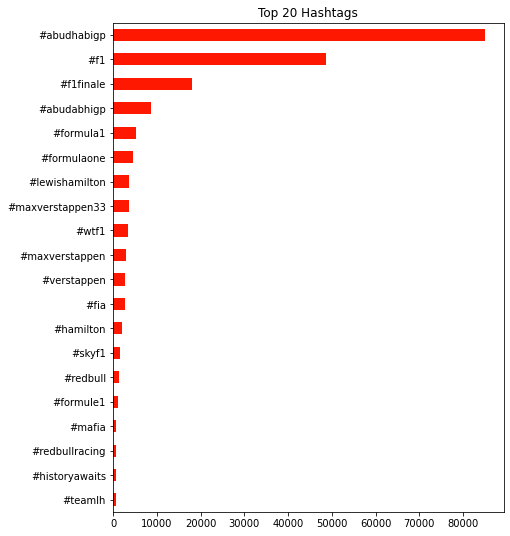

In [ ]:
pd.Series(['#' + x for x in all_hashtags]).value_counts().head(20)\
.sort_values().plot(kind = 'barh', color = '#FF1801', figsize = (7, 9))
plt.title('Top 20 Hashtags')